# SINDy and Neural SINDy Learning of Equations


Discovered equations:
dx/dt = -10.000*x +10.000*y
dy/dt = +27.717*x -0.941*y -0.991*x*z
dz/dt = -2.665*z +0.998*x*y


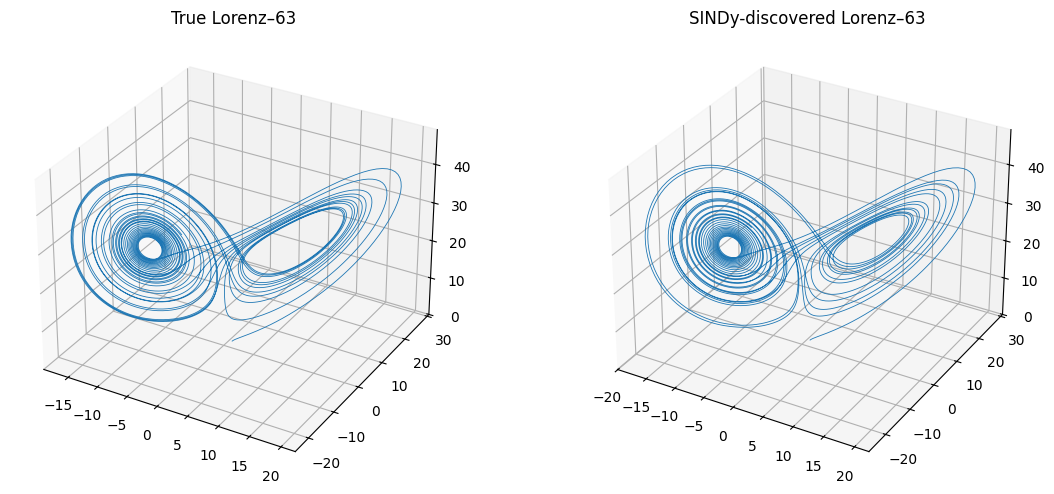


Saved: SINDy_01.png


In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ------------------------------------------------------------
# Phase 1: Generate Lorenz-63 data
# ------------------------------------------------------------
sigma = 10.0
rho   = 28.0
beta  = 8.0 / 3.0

def lorenz63_true(t, X):
    x, y, z = X
    return [
        sigma * (y - x),
        x * (rho - z) - y,
        x * y - beta * z
    ]

t_span = (0.0, 25.0)
t_eval = np.linspace(*t_span, 5000)
x0 = [1.0, 1.0, 1.0]

sol = solve_ivp(lorenz63_true, t_span, x0, t_eval=t_eval)
X = sol.y.T
dt = t_eval[1] - t_eval[0]

# Numerical derivatives
dXdt = np.gradient(X, dt, axis=0)

# ------------------------------------------------------------
# Phase 2: SINDy REGRESSION (this is where Xi is computed)
# ------------------------------------------------------------
x, y, z = X.T

Theta = np.column_stack([
    np.ones_like(x),
    x, y, z,
    x * y,
    x * z,
    y * z
])

feature_names = ["1", "x", "y", "z", "x*y", "x*z", "y*z"]

def sindy(Theta, dXdt, lam=0.1, n_iter=10):
    # ---- REGRESSION #1 (dense)
    Xi = np.linalg.lstsq(Theta, dXdt, rcond=None)[0]

    for _ in range(n_iter):
        small = np.abs(Xi) < lam
        Xi[small] = 0.0

        # ---- REGRESSION #2 (sparse refit)
        for i in range(dXdt.shape[1]):
            big = ~small[:, i]
            Xi[big, i] = np.linalg.lstsq(
                Theta[:, big], dXdt[:, i], rcond=None
            )[0]
    return Xi

Xi = sindy(Theta, dXdt)

print("\nDiscovered equations:")
for i, var in enumerate(["x", "y", "z"]):
    terms = [
        f"{Xi[j,i]:+.3f}*{feature_names[j]}"
        for j in range(len(feature_names))
        if abs(Xi[j,i]) > 1e-6
    ]
    print(f"d{var}/dt =", " ".join(terms))

# ------------------------------------------------------------
# Phase 3: Integrate discovered system and compare
# ------------------------------------------------------------
Xi_sindy = Xi.copy()

def lorenz63_sindy(t, X):
    x, y, z = X
    Theta_vec = np.array([
        1.0,
        x, y, z,
        x * y,
        x * z,
        y * z
    ])
    return (Theta_vec @ Xi_sindy).tolist()

t_span = (0.0, 30.0)
t_eval = np.linspace(*t_span, 6000)

sol_true = solve_ivp(lorenz63_true, t_span, x0, t_eval=t_eval)
sol_sindy = solve_ivp(lorenz63_sindy, t_span, x0, t_eval=t_eval)

# ------------------------------------------------------------
# Plot and save
# ------------------------------------------------------------
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121, projection="3d")
ax1.plot(sol_true.y[0], sol_true.y[1], sol_true.y[2], lw=0.6)
ax1.set_title("True Lorenz–63")

ax2 = fig.add_subplot(122, projection="3d")
ax2.plot(sol_sindy.y[0], sol_sindy.y[1], sol_sindy.y[2], lw=0.6)
ax2.set_title("SINDy-discovered Lorenz–63")

plt.tight_layout()
plt.savefig("SINDy_01.png", dpi=200)
plt.show()

print("\nSaved: SINDy_01.png")


Generated 2000 points of Lorenz-63 data
Noise level: 0.5
Computed numerical derivatives, shape: (2000, 3)
Library shape: (2000, 10)
Features: ['1', 'x', 'y', 'z', 'xy', 'xz', 'yz', 'x²', 'y²', 'z²']

DISCOVERED EQUATIONS:
dx/dt = -9.41*x +9.45*y
dy/dt = +26.74*x -0.65*y -0.97*xz
dz/dt = -2.63*z +0.99*xy

True Lorenz-63 equations:
dx/dt = +10.00*y -10.00*x
dy/dt = +28.00*x -1.00*y -1.00*xz
dz/dt = +1.00*xy -2.67*z

Mean squared error: 70.9128


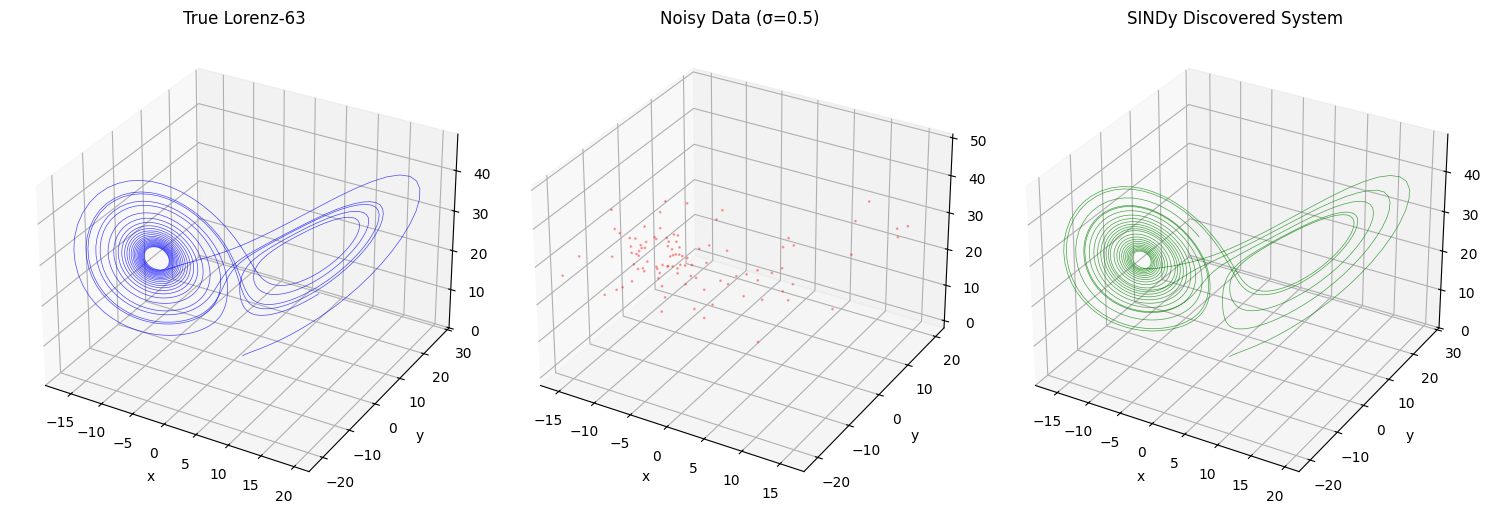


Saved plot as 'sindy_lorenz63.png'


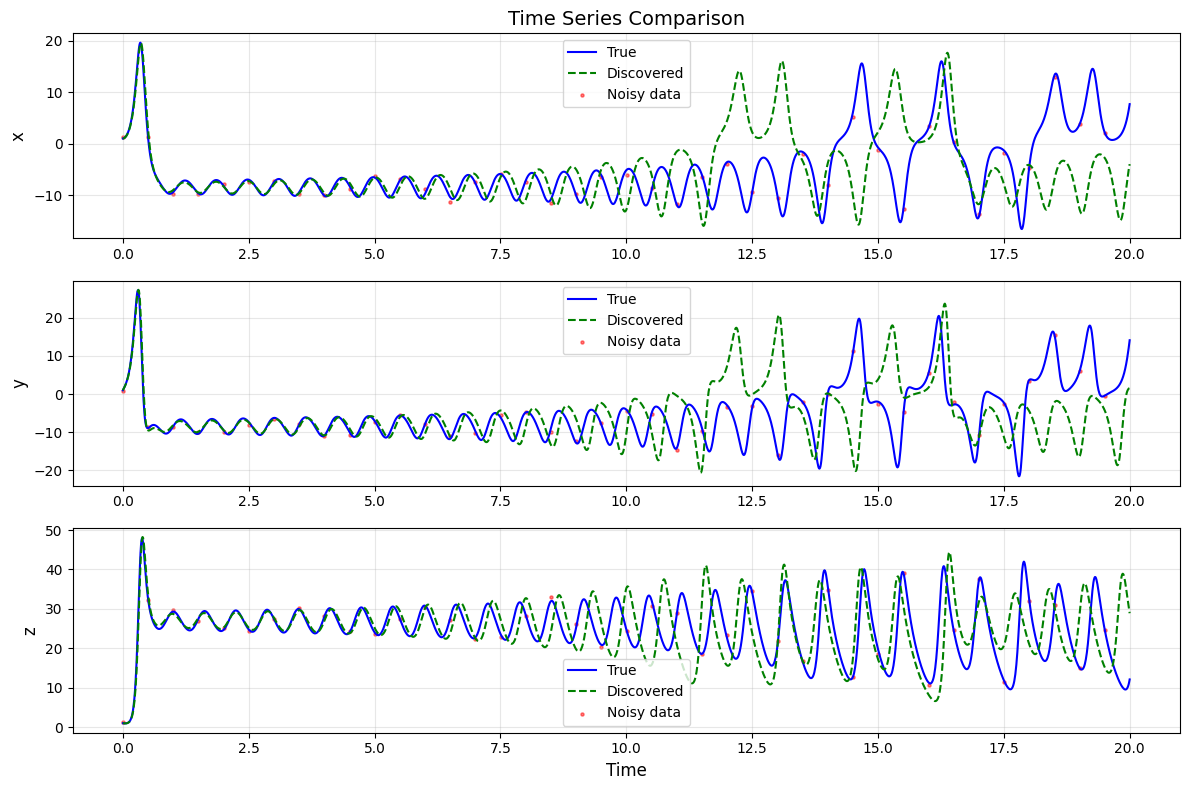

Saved time series plot as 'sindy_timeseries.png'


In [14]:
# ============================================================
# SINDy: Sparse Identification of Nonlinear Dynamics
# Discover the Lorenz-63 system from noisy trajectory data
# ============================================================
import torch
import torch.nn as nn
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(42)
torch.manual_seed(42)

# ------------------------------------------------------------
# Generate true Lorenz-63 data
# ------------------------------------------------------------
def lorenz63(t, X, sigma=10.0, rho=28.0, beta=8.0/3.0):
    x, y, z = X
    return [
        sigma * (y - x),
        x * (rho - z) - y,
        x * y - beta * z
    ]

# Initial condition and time span
x0 = [1.0, 1.0, 1.0]
t_span = (0, 20)
t_eval = np.linspace(0, 20, 2000)

# Solve true system
sol = solve_ivp(lorenz63, t_span, x0, t_eval=t_eval, method='RK45')
X_true = sol.y.T  # Shape: (2000, 3)

# Add noise
noise_level = 0.5
X_noisy = X_true + noise_level * np.random.randn(*X_true.shape)

print(f"Generated {len(t_eval)} points of Lorenz-63 data")
print(f"Noise level: {noise_level}")

# ------------------------------------------------------------
# Compute derivatives using finite differences
# ------------------------------------------------------------
def finite_diff_derivative(X, t):
    """Central differences for interior, forward/backward at edges"""
    dt = t[1] - t[0]
    dXdt = np.zeros_like(X)
    
    # Forward difference at start
    dXdt[0] = (X[1] - X[0]) / dt
    
    # Central difference in middle
    for i in range(1, len(X) - 1):
        dXdt[i] = (X[i+1] - X[i-1]) / (2 * dt)
    
    # Backward difference at end
    dXdt[-1] = (X[-1] - X[-2]) / dt
    
    return dXdt

dXdt_numerical = finite_diff_derivative(X_noisy, t_eval)

print(f"Computed numerical derivatives, shape: {dXdt_numerical.shape}")

# ------------------------------------------------------------
# Build library of candidate functions
# ------------------------------------------------------------
def build_library(X):
    """
    Build library of polynomial terms up to degree 3
    For Lorenz: need 1, x, y, z, xy, xz, yz, x^2, y^2, z^2
    """
    x, y, z = X[:, 0], X[:, 1], X[:, 2]
    
    library = np.column_stack([
        np.ones_like(x),  # 0: constant
        x,                # 1: x
        y,                # 2: y  
        z,                # 3: z
        x*y,              # 4: xy
        x*z,              # 5: xz
        y*z,              # 6: yz
        x**2,             # 7: x²
        y**2,             # 8: y²
        z**2,             # 9: z²
    ])
    
    return library

feature_names = ['1', 'x', 'y', 'z', 'xy', 'xz', 'yz', 'x²', 'y²', 'z²']

Theta = build_library(X_noisy)
print(f"Library shape: {Theta.shape}")
print(f"Features: {feature_names}")

# ------------------------------------------------------------
# Sparse regression with sequential thresholding
# ------------------------------------------------------------
def sparse_regression(Theta, dXdt, alpha=0.01, threshold=0.01, max_iter=10):
    """
    Sequential thresholded least squares (STLSQ)
    """
    n_features = Theta.shape[1]
    n_vars = dXdt.shape[1]
    Xi = np.zeros((n_features, n_vars))
    
    for i in range(n_vars):
        # Use Lasso for initial sparse solution
        model = Lasso(alpha=alpha, fit_intercept=False, max_iter=5000)
        model.fit(Theta, dXdt[:, i])
        Xi[:, i] = model.coef_
        
        # Sequential thresholding
        for iteration in range(max_iter):
            # Threshold small coefficients
            small_inds = np.abs(Xi[:, i]) < threshold
            Xi[small_inds, i] = 0
            
            # Refit on remaining terms
            big_inds = ~small_inds
            if np.sum(big_inds) > 0:
                Xi[big_inds, i] = np.linalg.lstsq(
                    Theta[:, big_inds], 
                    dXdt[:, i], 
                    rcond=None
                )[0]
    
    return Xi

# Discover coefficients
Xi_discovered = sparse_regression(Theta, dXdt_numerical, alpha=0.05, threshold=0.5)

# ------------------------------------------------------------
# Print discovered equations
# ------------------------------------------------------------
print("\n" + "="*60)
print("DISCOVERED EQUATIONS:")
print("="*60)

var_names = ['x', 'y', 'z']
for i, var in enumerate(var_names):
    terms = []
    for j, fname in enumerate(feature_names):
        coef = Xi_discovered[j, i]
        if abs(coef) > 0.01:
            terms.append(f"{coef:+.2f}*{fname}")
    
    eq = " ".join(terms) if terms else "0"
    print(f"d{var}/dt = {eq}")

print("\nTrue Lorenz-63 equations:")
print("dx/dt = +10.00*y -10.00*x")
print("dy/dt = +28.00*x -1.00*y -1.00*xz")
print("dz/dt = +1.00*xy -2.67*z")
print("="*60)

# ------------------------------------------------------------
# Integrate discovered system
# ------------------------------------------------------------
def discovered_system(t, X):
    x, y, z = X
    state_vec = np.array([1, x, y, z, x*y, x*z, y*z, x**2, y**2, z**2])
    dX = Xi_discovered.T @ state_vec
    return dX.tolist()

# Integrate from same initial condition
sol_discovered = solve_ivp(
    discovered_system, 
    t_span, 
    x0, 
    t_eval=t_eval, 
    method='RK45'
)

X_discovered = sol_discovered.y.T

# Compute error
error = np.mean((X_true - X_discovered)**2)
print(f"\nMean squared error: {error:.4f}")

# ------------------------------------------------------------
# Visualization
# ------------------------------------------------------------
fig = plt.figure(figsize=(15, 5))

# True system
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot(X_true[:, 0], X_true[:, 1], X_true[:, 2], 'b-', linewidth=0.5, alpha=0.7)
ax1.set_title('True Lorenz-63', fontsize=12)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

# Noisy observations
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(X_noisy[::20, 0], X_noisy[::20, 1], X_noisy[::20, 2], 
            c='red', s=1, alpha=0.3)
ax2.set_title(f'Noisy Data (σ={noise_level})', fontsize=12)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')

# Discovered system
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot(X_discovered[:, 0], X_discovered[:, 1], X_discovered[:, 2], 
         'g-', linewidth=0.5, alpha=0.7)
ax3.set_title('SINDy Discovered System', fontsize=12)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')

plt.tight_layout()
plt.savefig('sindy_lorenz63.png', dpi=150)
plt.show()

print("\nSaved plot as 'sindy_lorenz63.png'")

# ------------------------------------------------------------
# Compare time series
# ------------------------------------------------------------
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

for i, (ax, var) in enumerate(zip(axes, ['x', 'y', 'z'])):
    ax.plot(t_eval, X_true[:, i], 'b-', label='True', linewidth=1.5)
    ax.plot(t_eval, X_discovered[:, i], 'g--', label='Discovered', linewidth=1.5)
    ax.scatter(t_eval[::50], X_noisy[::50, i], c='red', s=5, 
               alpha=0.5, label='Noisy data')
    ax.set_ylabel(var, fontsize=12)
    ax.legend()
    ax.grid(alpha=0.3)

axes[-1].set_xlabel('Time', fontsize=12)
axes[0].set_title('Time Series Comparison', fontsize=14)

plt.tight_layout()
plt.savefig('sindy_timeseries.png', dpi=150)
plt.show()

print("Saved time series plot as 'sindy_timeseries.png'")

Using device: mps
Generated 1000 points
High noise level: 2.0 (to demonstrate NN smoothing)

Training neural network to smooth trajectory...
Epoch 1000/45000, Loss: 51.734436
Epoch 2000/45000, Loss: 45.701591
Epoch 3000/45000, Loss: 45.150036
Epoch 4000/45000, Loss: 36.370281
Epoch 5000/45000, Loss: 34.208881
Epoch 6000/45000, Loss: 33.267143
Epoch 7000/45000, Loss: 32.632595
Epoch 8000/45000, Loss: 32.615887
Epoch 9000/45000, Loss: 32.219246
Epoch 10000/45000, Loss: 31.495138
Epoch 11000/45000, Loss: 30.579218
Epoch 12000/45000, Loss: 29.908817
Epoch 13000/45000, Loss: 27.459484
Epoch 14000/45000, Loss: 22.811161
Epoch 15000/45000, Loss: 16.572292
Epoch 16000/45000, Loss: 13.090780
Epoch 17000/45000, Loss: 10.565555
Epoch 18000/45000, Loss: 9.373476
Epoch 19000/45000, Loss: 8.502758
Epoch 20000/45000, Loss: 8.387770
Epoch 21000/45000, Loss: 7.802353
Epoch 22000/45000, Loss: 8.019754
Epoch 23000/45000, Loss: 7.508661
Epoch 24000/45000, Loss: 7.830100
Epoch 25000/45000, Loss: 7.328603
E

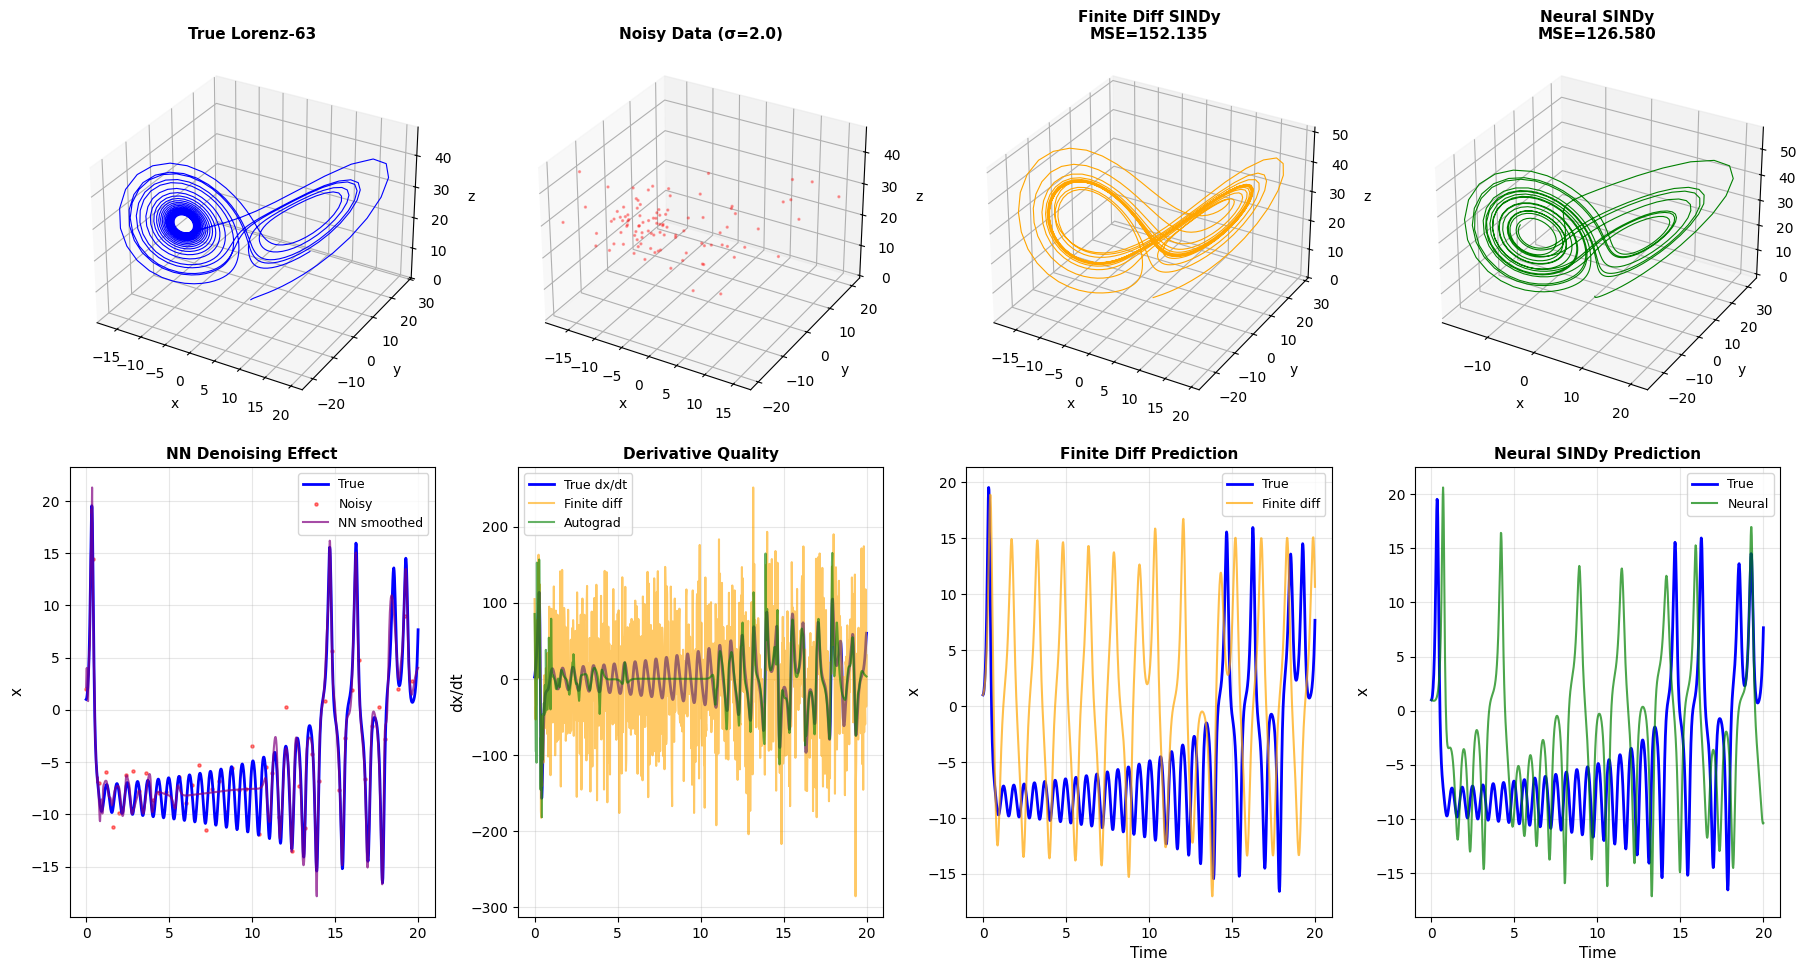


Saved comparison plot as 'neural_sindy_comparison.png'


In [23]:
# ============================================================
# Neural SINDy: Use NN to denoise trajectory, then discover equations
# Compares: (1) Finite differences, (2) NN + autograd derivatives
# ============================================================
import torch
import torch.nn as nn
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(42)
torch.manual_seed(42)

# ------------------------------------------------------------
# Device
# ------------------------------------------------------------
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# ------------------------------------------------------------
# Generate true Lorenz-63 data with HIGH NOISE
# ------------------------------------------------------------
def lorenz63(t, X, sigma=10.0, rho=28.0, beta=8.0/3.0):
    x, y, z = X
    return [
        sigma * (y - x),
        x * (rho - z) - y,
        x * y - beta * z
    ]

x0 = [1.0, 1.0, 1.0]
t_span = (0, 20)
t_eval = np.linspace(0, 20, 1000)

sol = solve_ivp(lorenz63, t_span, x0, t_eval=t_eval, method='RK45')
X_true = sol.y.T

# HIGH noise to show NN advantage
noise_level = 2.0
X_noisy = X_true + noise_level * np.random.randn(*X_true.shape)

print(f"Generated {len(t_eval)} points")
print(f"High noise level: {noise_level} (to demonstrate NN smoothing)")

# ------------------------------------------------------------
# Method 1: Classical finite differences (noisy derivatives)
# ------------------------------------------------------------
def finite_diff_derivative(X, t):
    dt = t[1] - t[0]
    dXdt = np.zeros_like(X)
    dXdt[0] = (X[1] - X[0]) / dt
    for i in range(1, len(X) - 1):
        dXdt[i] = (X[i+1] - X[i-1]) / (2 * dt)
    dXdt[-1] = (X[-1] - X[-2]) / dt
    return dXdt

dXdt_finite_diff = finite_diff_derivative(X_noisy, t_eval)

# ------------------------------------------------------------
# Method 2: Neural Network to learn smooth trajectory
# ------------------------------------------------------------
class TrajectoryNet(nn.Module):
    """
    Network maps time -> state (x, y, z)
    Architecture designed for smooth interpolation
    """
    def __init__(self, hidden_dim=128, n_layers=4):
        super().__init__()
        
        layers = []
        layers.append(nn.Linear(1, hidden_dim))
        layers.append(nn.Tanh())
        
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        
        layers.append(nn.Linear(hidden_dim, 3))
        
        self.net = nn.Sequential(*layers)
        
        # Xavier initialization
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
    
    def forward(self, t):
        return self.net(t)

# Convert to tensors
t_tensor = torch.tensor(t_eval, dtype=torch.float32, device=device).view(-1, 1)
X_noisy_tensor = torch.tensor(X_noisy, dtype=torch.float32, device=device)

# Normalize time for training stability
t_min, t_max = t_tensor.min(), t_tensor.max()
t_normalized = (t_tensor - t_min) / (t_max - t_min)

# Create model
model = TrajectoryNet(hidden_dim=128, n_layers=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
print("\nTraining neural network to smooth trajectory...")
epochs = 45000
for epoch in range(epochs):
    optimizer.zero_grad()
    
    X_pred = model(t_normalized)
    loss = torch.mean((X_pred - X_noisy_tensor) ** 2)
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

# ------------------------------------------------------------
# Extract smooth trajectory and compute autograd derivatives
# ------------------------------------------------------------
model.eval()

# Need to track gradients for derivatives
t_normalized.requires_grad_(True)

X_smooth = model(t_normalized)

# Compute derivatives via autograd
print("\nComputing derivatives via autograd...")
dXdt_autograd = []

for i in range(3):  # For each dimension
    # Compute gradient of output i w.r.t. time
    grad = torch.autograd.grad(
        outputs=X_smooth[:, i].sum(),
        inputs=t_normalized,
        create_graph=False,
        retain_graph=True
    )[0]
    
    # Account for time normalization: d/dt = d/dt_norm * dt_norm/dt
    grad = grad / (t_max - t_min)
    dXdt_autograd.append(grad)

dXdt_autograd = torch.stack(dXdt_autograd, dim=1)

# Convert to numpy
X_smooth_np = X_smooth.detach().cpu().numpy()
dXdt_autograd_np = dXdt_autograd.detach().cpu().numpy()

print(f"Smooth trajectory shape: {X_smooth_np.shape}")
print(f"Autograd derivatives shape: {dXdt_autograd_np.shape}")

# ------------------------------------------------------------
# SINDy sparse regression (shared function)
# ------------------------------------------------------------
def build_library(X):
    x, y, z = X[:, 0], X[:, 1], X[:, 2]
    library = np.column_stack([
        np.ones_like(x),
        x, y, z,
        x*y, x*z, y*z,
        x**2, y**2, z**2
    ])
    return library

feature_names = ['1', 'x', 'y', 'z', 'xy', 'xz', 'yz', 'x²', 'y²', 'z²']

def sparse_regression(Theta, dXdt, alpha=0.02, threshold=0.1, max_iter=10):
    """
    Sequential thresholded least squares with proper scaling
    """
    n_features = Theta.shape[1]
    n_vars = dXdt.shape[1]
    Xi = np.zeros((n_features, n_vars))
    
    # Normalize features for better conditioning
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler(with_mean=False)
    Theta_scaled = scaler.fit_transform(Theta)
    
    for i in range(n_vars):
        # Use scaled features, increase iterations, adjust tolerance
        model = Lasso(alpha=alpha, fit_intercept=False, max_iter=50000, 
                     tol=1e-3, warm_start=True)
        
        try:
            model.fit(Theta_scaled, dXdt[:, i])
            # Unscale coefficients
            Xi[:, i] = model.coef_ / scaler.scale_
        except:
            # Fallback to least squares if Lasso fails
            Xi[:, i] = np.linalg.lstsq(Theta, dXdt[:, i], rcond=None)[0].ravel()
            continue
        
        # Sequential thresholding
        for iteration in range(max_iter):
            small_inds = np.abs(Xi[:, i]) < threshold
            Xi[small_inds, i] = 0
            
            big_inds = ~small_inds
            if np.sum(big_inds) > 0:
                # Refit on unscaled features
                coef = np.linalg.lstsq(
                    Theta[:, big_inds], 
                    dXdt[:, i], 
                    rcond=None
                )[0]
                Xi[big_inds, i] = coef.ravel()
    
    return Xi

# ------------------------------------------------------------
# Apply SINDy with both methods
# ------------------------------------------------------------
print("\n" + "="*70)
print("METHOD 1: Classical SINDy (Finite Differences on Noisy Data)")
print("="*70)

Theta_noisy = build_library(X_noisy)
Xi_finite_diff = sparse_regression(Theta_noisy, dXdt_finite_diff, alpha=0.1, threshold=0.5)

for i, var in enumerate(['x', 'y', 'z']):
    terms = []
    for j, fname in enumerate(feature_names):
        coef = Xi_finite_diff[j, i]
        if abs(coef) > 0.01:
            terms.append(f"{coef:+.2f}*{fname}")
    eq = " ".join(terms) if terms else "0"
    print(f"d{var}/dt = {eq}")

print("\n" + "="*70)
print("METHOD 2: Neural SINDy (NN Smoothing + Autograd Derivatives)")
print("="*70)

Theta_smooth = build_library(X_smooth_np)
Xi_neural = sparse_regression(Theta_smooth, dXdt_autograd_np, alpha=0.02, threshold=0.1)

for i, var in enumerate(['x', 'y', 'z']):
    terms = []
    for j, fname in enumerate(feature_names):
        coef = Xi_neural[j, i]
        if abs(coef) > 0.01:
            terms.append(f"{coef:+.2f}*{fname}")
    eq = " ".join(terms) if terms else "0"
    print(f"d{var}/dt = {eq}")

print("\n" + "="*70)
print("TRUE LORENZ-63 EQUATIONS:")
print("="*70)
print("dx/dt = -10.00*x +10.00*y")
print("dy/dt = +28.00*x -1.00*y -1.00*xz")
print("dz/dt = +1.00*xy -2.67*z")
print("="*70)

# ------------------------------------------------------------
# Integrate both discovered systems
# ------------------------------------------------------------
def system_from_Xi(Xi):
    def system(t, X):
        x, y, z = X
        state_vec = np.array([1, x, y, z, x*y, x*z, y*z, x**2, y**2, z**2])
        dX = Xi.T @ state_vec
        return dX.tolist()
    return system

sol_finite_diff = solve_ivp(
    system_from_Xi(Xi_finite_diff),
    t_span, x0, t_eval=t_eval, method='RK45'
)

sol_neural = solve_ivp(
    system_from_Xi(Xi_neural),
    t_span, x0, t_eval=t_eval, method='RK45'
)

# Compute errors
error_finite_diff = np.mean((X_true - sol_finite_diff.y.T)**2)
error_neural = np.mean((X_true - sol_neural.y.T)**2)

print(f"\nMSE (Finite Diff): {error_finite_diff:.4f}")
print(f"MSE (Neural SINDy): {error_neural:.4f}")
print(f"Improvement: {(1 - error_neural/error_finite_diff)*100:.1f}%")

# ------------------------------------------------------------
# Visualization
# ------------------------------------------------------------
fig = plt.figure(figsize=(18, 10))

# Row 1: 3D trajectories
ax1 = fig.add_subplot(2, 4, 1, projection='3d')
ax1.plot(X_true[:, 0], X_true[:, 1], X_true[:, 2], 'b-', linewidth=0.8)
ax1.set_title('True Lorenz-63', fontsize=11, fontweight='bold')
ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax1.set_zlabel('z')

ax2 = fig.add_subplot(2, 4, 2, projection='3d')
ax2.scatter(X_noisy[::10, 0], X_noisy[::10, 1], X_noisy[::10, 2], 
            c='red', s=2, alpha=0.3)
ax2.set_title(f'Noisy Data (σ={noise_level})', fontsize=11, fontweight='bold')
ax2.set_xlabel('x'); ax2.set_ylabel('y'); ax2.set_zlabel('z')

ax3 = fig.add_subplot(2, 4, 3, projection='3d')
ax3.plot(sol_finite_diff.y[0], sol_finite_diff.y[1], sol_finite_diff.y[2], 
         'orange', linewidth=0.8)
ax3.set_title(f'Finite Diff SINDy\nMSE={error_finite_diff:.3f}', 
              fontsize=11, fontweight='bold')
ax3.set_xlabel('x'); ax3.set_ylabel('y'); ax3.set_zlabel('z')

ax4 = fig.add_subplot(2, 4, 4, projection='3d')
ax4.plot(sol_neural.y[0], sol_neural.y[1], sol_neural.y[2], 
         'green', linewidth=0.8)
ax4.set_title(f'Neural SINDy\nMSE={error_neural:.3f}', 
              fontsize=11, fontweight='bold')
ax4.set_xlabel('x'); ax4.set_ylabel('y'); ax4.set_zlabel('z')

# Row 2: Time series comparison for x coordinate
ax5 = fig.add_subplot(2, 4, 5)
ax5.plot(t_eval, X_true[:, 0], 'b-', label='True', linewidth=2)
ax5.scatter(t_eval[::20], X_noisy[::20, 0], c='red', s=5, alpha=0.5, label='Noisy')
ax5.plot(t_eval, X_smooth_np[:, 0], 'purple', linewidth=1.5, 
         alpha=0.7, label='NN smoothed')
ax5.set_ylabel('x', fontsize=11)
ax5.legend(fontsize=9)
ax5.grid(alpha=0.3)
ax5.set_title('NN Denoising Effect', fontsize=11, fontweight='bold')

# Derivative comparison
ax6 = fig.add_subplot(2, 4, 6)
dt = t_eval[1] - t_eval[0]
dx_true = np.gradient(X_true[:, 0], dt)
ax6.plot(t_eval, dx_true, 'b-', label='True dx/dt', linewidth=2)
ax6.plot(t_eval, dXdt_finite_diff[:, 0], 'orange', alpha=0.6, 
         label='Finite diff', linewidth=1.5)
ax6.plot(t_eval, dXdt_autograd_np[:, 0], 'green', alpha=0.6, 
         label='Autograd', linewidth=1.5)
ax6.set_ylabel('dx/dt', fontsize=11)
ax6.legend(fontsize=9)
ax6.grid(alpha=0.3)
ax6.set_title('Derivative Quality', fontsize=11, fontweight='bold')

# Long-term prediction x
ax7 = fig.add_subplot(2, 4, 7)
ax7.plot(t_eval, X_true[:, 0], 'b-', label='True', linewidth=2)
ax7.plot(t_eval, sol_finite_diff.y[0], 'orange', alpha=0.7, 
         label='Finite diff', linewidth=1.5)
ax7.set_xlabel('Time', fontsize=11)
ax7.set_ylabel('x', fontsize=11)
ax7.legend(fontsize=9)
ax7.grid(alpha=0.3)
ax7.set_title('Finite Diff Prediction', fontsize=11, fontweight='bold')

# Long-term prediction neural
ax8 = fig.add_subplot(2, 4, 8)
ax8.plot(t_eval, X_true[:, 0], 'b-', label='True', linewidth=2)
ax8.plot(t_eval, sol_neural.y[0], 'green', alpha=0.7, 
         label='Neural', linewidth=1.5)
ax8.set_xlabel('Time', fontsize=11)
ax8.set_ylabel('x', fontsize=11)
ax8.legend(fontsize=9)
ax8.grid(alpha=0.3)
ax8.set_title('Neural SINDy Prediction', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('neural_sindy_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved comparison plot as 'neural_sindy_comparison.png'")